In [ ]:
# === CONFIG  ===
DRIVE_DIR = Path("/content/drive/MyDrive/sih_models")
WEIGHTS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)



In [ ]:
# UPLOADING DATASET
from google.colab import files
from pathlib import Path

uploaded = files.upload()  # upload a zip file

!rm -rf /content/zooplankton_images_dataset
!unzip -q zooplankton_images_dataset.zip -d /content/zooplankton_images_dataset

DATA_ROOT = Path("/content/zooplankton_images_dataset")
print("Dataset ready at", DATA_ROOT)


In [ ]:
#FINDING TOTAL NUMBER OF CLASSES AND IMAGES ACROSS THEM
from pathlib import Path
DATA_ROOT = Path("/content/zooplankton_images_dataset/zooplankton_images_dataset")  #  inner zooplankton image folder
class_dirs=sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])    #list of subfolders named after zooplanktons

def count_images_in_dir(d):   #iterating over and counting each image
  imgs= [p for p in d.rglob("*")if p.suffix.lower()in [".jpg",".jpeg",".png",".bpm",".tif",".tiff"]]
  return len(imgs),imgs[:3]
print("Root Path: ",DATA_ROOT)
total=0
for d in class_dirs[:50]:
  ccount,examples =count_images_in_dir(d)
  total += ccount
  print(f"-{d.name:25s} : {ccount:4d} images")
print("Total images across all classes:",total)  #total images

In [ ]:
#NAMING AND CREATING CLASS FILE WITH SPECIE NAME

from pathlib import Path
ROOT2=Path(r"/content/zooplankton_images_dataset/zooplankton_images_dataset")

#getting the class folder names
class_dirs=sorted([d for d in ROOT2.iterdir() if d.is_dir()])

#creating a file and writing all class names
classes_file=ROOT2/"classes.txt"
with classes_file.open("w",encoding="utf8") as f:
  for d in class_dirs:
    f.write(d.name + "\n")
print("classes.txt is created at : ", classes_file)
print("Preview Classes :",classes_file.read_text(encoding="utf8").splitlines()[:10])

In [ ]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# defining project folder on Drive to save model and checkpoints
DRIVE_PROJECT = "/content/drive/MyDrive/sih_models"
import os
os.makedirs(DRIVE_PROJECT, exist_ok=True)
print("Drive mounted. Project folder:", DRIVE_PROJECT)


In [ ]:
#SPLITTING TO TRAIN,TEST AND VAL

import random, shutil
from pathlib import Path
from PIL import Image

ROOT = Path("/content/zooplankton_images_dataset/zooplankton_images_dataset")  # inner folder
OUT = Path("/content/plankton_dataset")
VAL_RATIO = 0.2
FULLBOX = 0.99

# deterministic split
random.seed(42)

#  output structure
for sub in ["images/train","images/val","labels/train","labels/val"]:
    (OUT/sub).mkdir(parents=True, exist_ok=True)

class_dirs = sorted([d for d in ROOT.iterdir() if d.is_dir()])
classes = [d.name for d in class_dirs]
print("Found classes:", len(classes))

# save classes.txt
(OUT/"classes.txt").write_text("\n".join(classes), encoding="utf8")

# collect all images recursively
pairs = []
for idx, d in enumerate(class_dirs):
    imgs = [p for p in d.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]]
    for p in imgs:
        pairs.append((p, idx, d.name))

random.shuffle(pairs)
n_val = int(len(pairs) * VAL_RATIO)
val_pairs, train_pairs = pairs[:n_val], pairs[n_val:]
print(f"Total images: {len(pairs)} | Train: {len(train_pairs)} | Val: {len(val_pairs)}")


def copy_and_label(pairs, kind):
    counters = {}
    for src, cls_idx, cls_name in pairs:
        counters.setdefault(cls_name, 0)
        counters[cls_name] += 1
        newname = f"{cls_name}__{counters[cls_name]:05d}{src.suffix.lower()}"
        dest_img = OUT / f"images/{kind}" / newname
        try:
            shutil.copy(src, dest_img)
            with Image.open(src) as im:
                w, h = im.size
            x_c, y_c, w_rel, h_rel = 0.5, 0.5, FULLBOX, FULLBOX
            # write label with 6 decimal places
            label_path = OUT / f"labels/{kind}" / (Path(newname).stem + ".txt")
            label_path.write_text(f"{cls_idx} {x_c:.6f} {y_c:.6f} {w_rel:.6f} {h_rel:.6f}\n")
        except Exception as e:
            print("Skipping", src, "error:", e)

copy_and_label(train_pairs, "train")
copy_and_label(val_pairs, "val")

# writing plankton.yaml using block format
yaml_lines = [
    f"path: {OUT}",
    "train: images/train",
    "val: images/val",
    f"nc: {len(classes)}",
    "names:"
]
yaml_lines += [f"  - {c}" for c in classes]
(OUT/"plankton.yaml").write_text("\n".join(yaml_lines), encoding="utf8")

print("YOLO dataset prepared at", OUT)


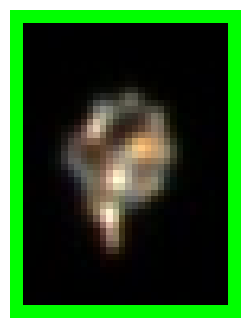

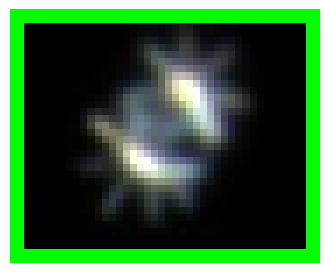

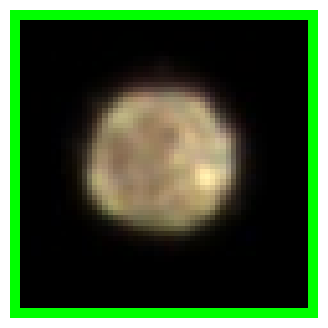

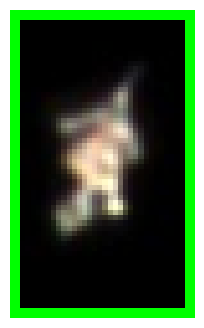

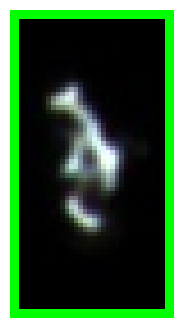

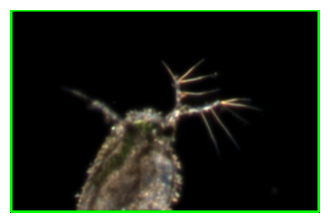

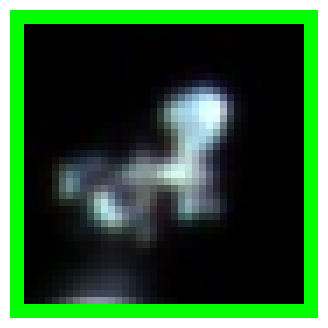

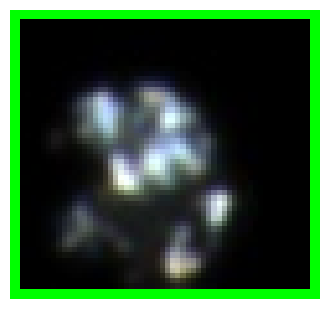

In [ ]:
#ADDING BOUNDING BOXES

import cv2, random, matplotlib.pyplot as plt

ROOT2 = Path("/content/plankton_dataset")
classes = [l.strip() for l in open(ROOT2/"classes.txt")]

imgs = list((ROOT2/"images"/"train").glob("*"))
random.shuffle(imgs)
for p in imgs[:8]:
    img = cv2.imread(str(p))
    h,w = img.shape[:2]
    lbl = ROOT2/"labels"/"train"/(p.stem + ".txt")
    for line in open(lbl):
        cls,x_c,y_c,w_rel,h_rel = line.split()
        cls=int(cls); x_c=float(x_c); y_c=float(y_c); w_rel=float(w_rel); h_rel=float(h_rel)
        x1=int((x_c - w_rel/2)*w); x2=int((x_c + w_rel/2)*w)
        y1=int((y_c - h_rel/2)*h); y2=int((y_c + h_rel/2)*h)
        cv2.rectangle(img, (x1,y1),(x2,y2),(0,255,0),2)
        cv2.putText(img, classes[cls], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(0,255,0),2)
    plt.figure(figsize=(4,4)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")


In [ ]:
#  DATASET SANITY CHECK (IMAGE VS LABEL)
from pathlib import Path
ROOT = Path("/content/plankton_dataset")  # update this if your dataset folder is elsewhere in Drive
print("Dataset root exists:", ROOT.exists())

for split in ("train","val"):
    img_dir = ROOT/"images"/split
    lab_dir = ROOT/"labels"/split
    imgs = sorted([p for p in img_dir.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]) if img_dir.exists() else []
    labs = sorted(list(lab_dir.glob("*.txt"))) if lab_dir.exists() else []
    img_stems = {p.stem for p in imgs}
    lab_stems = {p.stem for p in labs}
    missing_labels = sorted(list(img_stems - lab_stems))
    orphan_labels  = sorted(list(lab_stems - img_stems))
    print(f"{split:5} images: {len(imgs):6} | labels: {len(labs):6}")
    print("  missing labels (first 20):", missing_labels[:20])
    print("  orphan labels  (first 20):", orphan_labels[:20])


In [ ]:
# SUBSET CREATION (accepts .jpeg, .jpg, .png, etc.)
import random, shutil
from pathlib import Path

SRC = Path("/content/plankton_dataset")
OUT_SMALL = Path("/content/plankton_dataset_small")
OUT_SMALL.mkdir(parents=True, exist_ok=True)

# Parameters
TRAIN_N = 1000
VAL_N   = 200
random.seed(42)

# Prepare folders
for sub in ["images/train","images/val","labels/train","labels/val"]:
    (OUT_SMALL/sub).mkdir(parents=True, exist_ok=True)

# Allowed extensions
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def collect_pairs(images_dir, labels_dir):
    imgs = [p for p in images_dir.glob("*") if p.suffix.lower() in EXTS]
    pairs = []
    for img in imgs:
        lab = labels_dir / (img.stem + ".txt")
        if lab.exists():
            pairs.append((img, lab))
    return pairs

train_pairs = collect_pairs(SRC/"images"/"train", SRC/"labels"/"train")
val_pairs   = collect_pairs(SRC/"images"/"val",   SRC/"labels"/"val")

print("Found train pairs:", len(train_pairs), "| val pairs:", len(val_pairs))

random.shuffle(train_pairs)
random.shuffle(val_pairs)

train_sel = train_pairs[:TRAIN_N]
val_sel   = val_pairs[:VAL_N]

def copy_pairs(pairs, split):
    for img, lab in pairs:
        shutil.copy(img, OUT_SMALL/f"images/{split}"/img.name)
        shutil.copy(lab, OUT_SMALL/f"labels/{split}"/lab.name)

copy_pairs(train_sel, "train")
copy_pairs(val_sel, "val")

# Write YAML
classes = Path("/content/plankton_dataset/classes.txt").read_text().splitlines()
yaml_lines = [
    f"path: {OUT_SMALL}",
    "train: images/train",
    "val: images/val",
    f"nc: {len(classes)}",
    "names:"
] + [f"  - {c}" for c in classes]
(OUT_SMALL/"plankton.yaml").write_text("\n".join(yaml_lines), encoding="utf8")

print("Subset ready at:", OUT_SMALL)
print("Train subset images:", len(list((OUT_SMALL/'images/train').glob('*'))))
print("Val subset images:", len(list((OUT_SMALL/'images/val').glob('*'))))


In [ ]:
# tO DETECT FULL-FRAME OR TINY LABELS
from pathlib import Path
from PIL import Image
ROOT = Path("/content/plankton_dataset")
BAD_FULL_THRESHOLD = 0.9   # area fraction > 90% considered full-box
BAD_TINY_THRESHOLD = 0.01  # area fraction < 1% considered tiny

bad_full = []
bad_tiny = []
missing = []

for split in ("train","val"):
    img_dir = ROOT/"images"/split
    lab_dir = ROOT/"labels"/split
    if not img_dir.exists():
        continue
    for img_path in sorted(img_dir.glob("*")):
        stem = img_path.stem
        lab_path = lab_dir/(stem + ".txt")
        if not lab_path.exists():
            missing.append(str(img_path))
            continue
        try:
            W,H = Image.open(img_path).size
        except Exception:
            continue
        for line in lab_path.read_text().strip().splitlines():
            parts = line.split()
            if len(parts) < 5:
                continue
            xc,yc,w_rel,h_rel = map(float, parts[1:5])
            area_rel = w_rel * h_rel
            if area_rel >= BAD_FULL_THRESHOLD:
                bad_full.append(str(img_path))
            if area_rel <= BAD_TINY_THRESHOLD:
                bad_tiny.append(str(img_path))

print("Missing label images (first 20):", missing[:20])
print("Full-image labels (first 20):", bad_full[:20])
print("Very small labels (first 20):", bad_tiny[:20])


In [ ]:
#IMPORTING YOLO MODEL

from ultralytics import YOLO

# let ultralytics download the proper, compatible checkpoint automatically
model = YOLO("yolov8s")


In [ ]:
# MODEL TRAINING

from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # small model, better than nano
model.train(
    data="/content/plankton_dataset_small/plankton.yaml",
    epochs=30,
    imgsz=320,
    batch=16,
    workers=2,
    patience=10,
    optimizer="AdamW",
    augment=True
)


In [ ]:
from pathlib import Path
from ultralytics import YOLO

# auto-find latest run
runs = sorted(Path("/content/runs/detect").glob("train*"))
if not runs:
    raise FileNotFoundError("No training runs found. Train first.")
run = runs[-1]
print("Using run:", run)

ckpt = run / "weights" / "best.pt"
if not ckpt.exists():
    ckpt = run / "weights" / "last.pt"
print("Checkpoint:", ckpt)

model = YOLO(str(ckpt))
val_results = model.val(data="/content/plankton_dataset_small/plankton.yaml", verbose=True)
print(val_results)


In [ ]:
# PREDICTING RESULTS

import cv2, matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# load checkpoint (auto from last run)
runs = sorted(Path("/content/runs/detect").glob("train*"))
run = runs[-1]
ckpt = run / "weights" / "best.pt"
if not ckpt.exists(): ckpt = run / "weights" / "last.pt"
print("Predicting with:", ckpt)

model = YOLO(str(ckpt))
IMG_DIR = Path("/content/plankton_dataset_small/images/val")
sample_imgs = sorted(list(IMG_DIR.glob("*.jpg")))[:5]

for img in sample_imgs:
    res = model.predict(source=str(img), conf=0.25, imgsz=640)[0]
    im = res.plot()  # Ultralytics built-in plotting
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(img.name)
    plt.show()


In [ ]:
# CREATING BACKUP

from pathlib import Path
import shutil

ROOT = Path("/content/plankton_dataset_small")
BK = ROOT.parent / "plankton_dataset_small_labels_backup"
shutil.rmtree(BK, ignore_errors=True)
shutil.copytree(ROOT/"labels", BK)
print("Backup created at:", BK)


In [ ]:
# CHECKING FOR BAD AND CORRUPTED LABELS

from pathlib import Path

root = Path("/content/plankton_dataset_small")

def count_bad(lbl_dir):
    count = 0
    for f in lbl_dir.glob("*.txt"):
        for ln in open(f).read().splitlines():
            parts = ln.split()
            if len(parts) >= 5:
                _, xc, yc, w, h = map(float, parts[:5])
                if w*h > 0.8:
                    count += 1
                    break
    return count

for split in ("train","val"):
    lbl_dir = root/"labels"/split
    print(split, "bad labels:", count_bad(lbl_dir))

# also check problematic folder if it exists
prob = root/"problematic_large_labels"
if prob.exists():
    print("Files inside quarantine folder:", len(list(prob.glob('*'))))
else:
    print("No quarantine folder found")


In [ ]:
# RECREATING THE SUBSET

from pathlib import Path
import random, shutil

SRC = Path("/content/plankton_dataset")           # full dataset root
DST = Path("/content/plankton_dataset_small")     # subset root
shutil.rmtree(DST, ignore_errors=True)            # clear old subset
DST.mkdir(parents=True, exist_ok=True)

for split, limit in (("train", 1000), ("val", 200)):
    imgs = sorted(list((SRC/"images"/split).glob("*")))
    labs = sorted(list((SRC/"labels"/split).glob("*.txt")))
    lab_by_stem = {p.stem: p for p in labs}
    pairs = [(img, lab_by_stem[img.stem]) for img in imgs if img.stem in lab_by_stem]
    random.shuffle(pairs)
    pairs = pairs[:limit]

    # make subfolders
    (DST/"images"/split).mkdir(parents=True, exist_ok=True)
    (DST/"labels"/split).mkdir(parents=True, exist_ok=True)

    for img, lbl in pairs:
        shutil.copy(img, DST/"images"/split/img.name)
        shutil.copy(lbl, DST/"labels"/split/lbl.name)

    print(f"{split}: copied {len(pairs)} pairs")

# quick count
for split in ("train","val"):
    print(split, "images:", len(list((DST/'images'/split).glob('*'))),
          "| labels:", len(list((DST/'labels'/split).glob('*.txt'))))


In [ ]:
# SHRINKING ALL GIANT BOXES (area > 0.8) BY FACTOR OF 0.6

from pathlib import Path

ROOT = Path("/content/plankton_dataset_small")
count = 0
for split in ("train","val"):
    for f in (ROOT/"labels"/split).glob("*.txt"):
        lines = f.read_text().strip().splitlines()
        if not lines:
            continue
        new_lines = []
        changed = False
        for ln in lines:
            cls, xc, yc, w, h = map(float, ln.split()[:5])
            if w*h > 0.8:
                w *= 0.6
                h *= 0.6
                changed = True
            new_lines.append(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
        if changed:
            f.write_text("\n".join(new_lines))
            count += 1
print("✅ Shrunk", count, "labels (area>0.8) with factor 0.6")


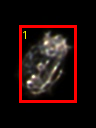

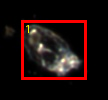

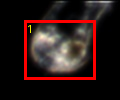

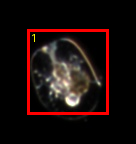

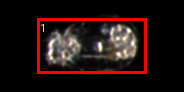

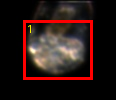

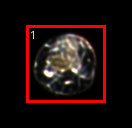

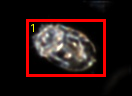

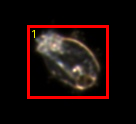

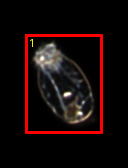

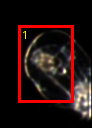

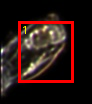

In [ ]:
# SAMPLE DISPLAY AFTER SHRINKING

from PIL import Image, ImageDraw
from pathlib import Path

root = Path("/content/plankton_dataset_small")
samples = sorted((root/"images"/"val").glob("*"))[:12]

for p in samples:
    img = Image.open(p).convert("RGB")
    w,h = img.size
    label = root/"labels"/"val"/(p.stem + ".txt")
    draw = ImageDraw.Draw(img)
    if label.exists():
        for ln in label.read_text().splitlines():
            cls, xc, yc, ww, hh = map(float, ln.split()[:5])
            x1 = (xc-ww/2)*w; y1 = (yc-hh/2)*h
            x2 = (xc+ww/2)*w; y2 = (yc+hh/2)*h
            draw.rectangle([x1,y1,x2,y2], outline="red", width=3)
            draw.text((x1+3, y1+3), str(int(cls)), fill="yellow")
    display(img)


In [ ]:
# SAMPLE TESTING

from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load  trained checkpoint
ckpt = "/content/runs/detect/train/weights/best.pt"
model = YOLO(ckpt)
print("Classes:", model.names)

# Run prediction
results = model.predict(
    source="/content/plankton_dataset_small/images/val/asplanchna__00043.jpeg",
    conf=0.25,
    save=False
)

# Plot
for r in results:
    im_array = r.plot(line_width=2, font_size=10)  # clean overlay
    plt.figure(figsize=(8,8))
    plt.imshow(im_array)
    plt.axis("off")
    plt.show()


In [ ]:
import os, shutil

src = "/content/plankton_dataset_small/labels"
dst = "/content/problematic_labels"
os.makedirs(dst, exist_ok=True)

for lbl in os.listdir(src + "/train"):
    f = os.path.join(src, "train", lbl)
    with open(f) as fp:
        lines = fp.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            _, xc, yc, w, h = map(float, parts)
            if w*h > 0.8:  # bad big label
                shutil.move(f, os.path.join(dst, lbl))
            else:
                new_lines.append(line)


In [ ]:
# mount + paths
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


DRIVE_PROJECT = "/content/drive/MyDrive/sih_models"
DATA_ROOT = Path("/content/plankton_dataset")
SMALL_ROOT = Path("/content/plankton_dataset_small")

# project folder
import os
os.makedirs(DRIVE_PROJECT, exist_ok=True)

print("Drive mounted. Project folder:", DRIVE_PROJECT)
print("Data root exists:", DATA_ROOT.exists())
print("Small root exists:", SMALL_ROOT.exists())


In [ ]:
# CREATING plankton.yaml FOR THE SMALL DATASET
from pathlib import Path
p = Path("/content/plankton_dataset_small/plankton.yaml")
content = f"""
train: {SMALL_ROOT}/images/train
val:   {SMALL_ROOT}/images/val
nc: 35
names: {SMALL_ROOT}/classes.txt
""".strip()

p.write_text(content)
print("Wrote:", p)
print(p.read_text())


In [ ]:
#  quarantine big labels (area>0.8)
from pathlib import Path
import shutil

root = SMALL_ROOT
quarantine = Path("/content/problematic_labels")
quarantine.mkdir(exist_ok=True)

moved = 0
for split in ("train","val"):
    lbl_dir = root/"labels"/split
    img_dir = root/"images"/split
    for txt in lbl_dir.glob("*.txt"):
        lines = txt.read_text().strip().splitlines()
        bad = False
        for l in lines:
            p = l.split()
            if len(p) != 5: continue
            _, xc, yc, w, h = map(float, p)
            if w*h > 0.8:
                bad = True
                break
        if bad:
            # move label and image to quarantine folder
            new_lbl = quarantine/f"{split}_label_{txt.name}"
            shutil.move(str(txt), str(new_lbl))
            # corresponding image (try common extensions)
            stem = txt.stem
            for ext in [".jpeg",".jpg",".png",".bmp"]:
                img = img_dir/(stem+ext)
                if img.exists():
                    new_img = quarantine/f"{split}_img_{img.name}"
                    shutil.move(str(img), str(new_img))
                    break
            moved += 1

print("Moved to quarantine:", moved)
print("Quarantine folder:", quarantine)


In [ ]:
#  REPLACE BIG LABELS WITH CENTERED SMALL BOXES
from pathlib import Path
root = SMALL_ROOT
count = 0
for split in ("train","val"):
    lbl_dir = root/"labels"/split
    for txt in lbl_dir.glob("*.txt"):
        lines = txt.read_text().strip().splitlines()
        new_lines = []
        changed = False
        for l in lines:
            parts = l.split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = parts
            xc, yc, w, h = map(float, (xc, yc, w, h))
            if w*h > 0.8:
                # set to centered half-size box (0.5 x 0.5)
                w2, h2 = 0.5, 0.5
                new_lines.append(f"{cls} {xc:.6f} {yc:.6f} {w2:.6f} {h2:.6f}")
                changed = True
            else:
                new_lines.append(l)
        if changed:
            txt.write_text("\n".join(new_lines))
            count += 1
print("Replaced big labels:", count)


In [ ]:
# IMAGE COUNTING AFTER CLEANING

root = SMALL_ROOT
for split in ("train","val"):
    imgs = list((root/"images"/split).glob("*"))
    lbls = list((root/"labels"/split).glob("*.txt"))
    print(f"{split}: images {len(imgs)} | labels {len(lbls)}")


In [ ]:
from pathlib import Path
ROOT = Path("/content")
SMALL = ROOT/"plankton_dataset_small"
MASTER_CANDIDATES = list(ROOT.rglob("classes.txt"))  # search whole /content

print("Found candidate classes.txt files:", len(MASTER_CANDIDATES))
for p in MASTER_CANDIDATES:
    print(" -", p)

# If any candidate found, copy the first
if MASTER_CANDIDATES:
    src = MASTER_CANDIDATES[0]
    dst = SMALL/"classes.txt"
    dst.parent.mkdir(parents=True, exist_ok=True)
    dst.write_text(src.read_text())
    print(f"Copied {src} -> {dst}")
else:
    print("No classes.txt found under /content. Will generate from image filenames in next cell.")


In [ ]:
from pathlib import Path
SMALL_ROOT = Path("/content/plankton_dataset_small")
CLASSES_FILE = SMALL_ROOT/"classes.txt"
YAML_FILE = SMALL_ROOT/"plankton.yaml"

if not CLASSES_FILE.exists():
    raise FileNotFoundError(f"{CLASSES_FILE} missing. Run previous cell to create it.")

names = [s.strip() for s in CLASSES_FILE.read_text().strip().splitlines() if s.strip()]
nc = len(names)

train_path = f"{SMALL_ROOT}/images/train"
val_path   = f"{SMALL_ROOT}/images/val"

yaml_text = f"""# Auto-generated by helper cell
train: {train_path}
val:   {val_path}

nc: {nc}
names: {names}
"""
YAML_FILE.write_text(yaml_text)
print("WROTE YAML:", YAML_FILE)
print("nc =", nc)
print("first lines:\n", "\n".join(YAML_FILE.read_text().splitlines()[:20]))


In [ ]:
from pathlib import Path
SMALL = Path("/content/plankton_dataset_small")
train_imgs = list((SMALL/"images"/"train").glob("*")) if (SMALL/"images"/"train").exists() else []
val_imgs   = list((SMALL/"images"/"val").glob("*"))   if (SMALL/"images"/"val").exists() else []
train_lbls = list((SMALL/"labels"/"train").glob("*.txt")) if (SMALL/"labels"/"train").exists() else []
val_lbls   = list((SMALL/"labels"/"val").glob("*.txt"))   if (SMALL/"labels"/"val").exists() else []

print("train images:", len(train_imgs), "train labels:", len(train_lbls))
print("val   images:", len(val_imgs), "val   labels:", len(val_lbls))
print("classes file exists:", (SMALL/"classes.txt").exists(), "classes count:", len(open(SMALL/"classes.txt").read().splitlines()) if (SMALL/"classes.txt").exists() else 0)
print("plankton.yaml exists:", (SMALL/"plankton.yaml").exists())
if (SMALL/"plankton.yaml").exists():
    print((SMALL/"plankton.yaml").read_text())


In [ ]:
from pathlib import Path
SMALL = Path("/content/plankton_dataset_small")
print("Exists small root:", SMALL.exists())
print("train images:", len(list((SMALL/"images"/"train").glob("*"))) )
print("train labels:", len(list((SMALL/"labels"/"train").glob("*.txt"))) )
print("val images:", len(list((SMALL/"images"/"val").glob("*"))) )
print("val labels:", len(list((SMALL/"labels"/"val").glob("*.txt"))) )
print("classes.txt exists:", (SMALL/"classes.txt").exists())
if (SMALL/"classes.txt").exists():
    print("classes count:", len((SMALL/"classes.txt").read_text().strip().splitlines()))
print("plankton.yaml exists:", (SMALL/"plankton.yaml").exists())
if (SMALL/"plankton.yaml").exists():
    print("---yaml---")
    print("\n".join((SMALL/"plankton.yaml").read_text().splitlines()[:20]))


In [ ]:
from pathlib import Path
SMALL = Path("/content/plankton_dataset_small")
prob = Path("/content/problematic_labels")
prob.mkdir(exist_ok=True)

moved = 0
TH = 0.80   # threshold: label area > TH will be quarantined
for split in ["train","val"]:
    lbl_dir = SMALL/"labels"/split
    if not lbl_dir.exists():
        continue
    for f in list(lbl_dir.glob("*.txt")):
        txt = f.read_text().strip().splitlines()
        keep = False
        for line in txt:
            parts = line.split()
            if len(parts) < 5:
                continue
            _, _, _, w, h = map(float, parts[:5])
            area = w * h
            if area > TH:
                # move both label and corresponding image
                img = (SMALL/"images"/split)/(f.stem + ".jpeg")
                if not img.exists():
                    img = (SMALL/"images"/split)/(f.stem + ".jpg")
                dest_lbl = prob/f"{split}_label_{f.name}"
                f.rename(dest_lbl)
                if img.exists():
                    dest_img = prob/f"{split}_img_{img.name}"
                    img.rename(dest_img)
                moved += 1
                break
print("Moved", moved, "problematic label files + images to", prob)


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")

model.train(
    data="/content/plankton_dataset_small/plankton.yaml",
    epochs=30,
    imgsz=320,
    batch=16,
    workers=2,
    project="/content/drive/MyDrive/sih_models",
    name="train_run1",
    save=True,
    optimizer="AdamW",
    augment=True
)


In [ ]:
from ultralytics import YOLO
model = YOLO("/content/models/best.pt")
print("Model loaded:", "/content/models/best.pt")


In [ ]:
from google.colab import files
import os

# Upload image(s) from your laptop
uploaded = files.upload()

# Make folder to store test images
os.makedirs("/content/test_images", exist_ok=True)

# Move uploaded files into test_images folder
for fname in uploaded.keys():
    os.rename(fname, f"/content/test_images/{fname}")

# Pick the first uploaded image for testing
sample_img = list(uploaded.keys())[0]
sample_path = f"/content/test_images/{sample_img}"

print("Running inference on:", sample_path)

# Run inference
results = model.predict(sample_path, save=True, imgsz=640, conf=0.13, iou=0.5, max_det=50)

print("Done. Check runs/predict/ for annotated results.")


In [ ]:
from collections import Counter
counts = Counter([model.names[int(box.cls)] for box in results[0].boxes])
print("Species counts:", counts)
